In [ ]:
import sys
import os
import numpy as np
import sktime
from sktime.datasets import load_from_tsfile_to_dataframe# Only add the project root to sys.path
root_path = os.path.abspath('..')
if root_path not in sys.path:
    sys.path.insert(0, root_path)
    
functions_path = os.path.abspath('../Functions')
data_path = os.path.abspath('../Data')
algorithms_path = os.path.abspath('../Algorithms')

sys.path.append(functions_path)
sys.path.append(data_path)
sys.path.append(algorithms_path)

In [ ]:
# x_train = load_from_tsfile_to_dataframe("..//Data//Physio//TEST_X.ts")
pid = np.load("..//Data//Physio//TEST_pid.npy")
print(pid)


In [ ]:
import numpy as np

# Load the data
pid = np.load("..//Data//Physio//TEST_pid.npy")

# Convert the fourth column to integers
fourth_col_as_int = np.array([int(row[3]) for row in pid])

# Sort the pid array based on the fourth column in descending order
pid_sorted_desc = pid[fourth_col_as_int.argsort()[::-1]]

print("Entries sorted in descending order of the fourth part:")
for row in pid_sorted_desc:
    print(row)


In [ ]:
import numpy as np
from collections import Counter

# Load the data
pid = np.load("..//Data//Physio//TRAIN_pid.npy")

# Extract the fourth column and convert it to integers
fourth_col_as_int = [int(row[3]) for row in pid]

# Count the occurrences of each number
count = Counter(fourth_col_as_int)

print("Count of each number in the fourth column:")
for number, count in sorted(count.items(), reverse=True):
    print(f"{number}: {count}")
    
pids_with_11 = [row[0] for row in pid if int(row[3]) == 11]

# Sort the collected PIDs
sorted_pids_with_11 = sorted(pids_with_11)

# Print sorted PIDs
print("Sorted PIDs of entries with '11' in the fourth column:")
for pid in sorted_pids_with_11:
    print(pid)

print(pid)

## Testing Binseg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg
from Functions.metrics import f_measure, covering

# Load the time series data from the uploaded file
ts_file_path = '..//Data//Physio//single_ts.ts'
dataset_name = 'single_ts'
with open(ts_file_path, 'r') as file:
    data = np.array([float(num) for num in file.read().split(',')])
    
print(data.size)
    
# Load the change points from the .npy file
# Make sure to update the file path to where your .npy file is located
npy_file_path = '..//Data//Physio//TEST_pid.npy'
change_points_list = np.load(npy_file_path, allow_pickle=True)

# Filter out non-numeric strings and convert the rest to integers, excluding the last number
true_change_points = [int(point) for point in change_points_list[0][:-1] if point.isdigit()]

# Parameters for the Binseg function
cost_func = "rbf"  # Example cost function
n_cps = len(true_change_points)
detected_cps = binseg(data, n_cps, cost_func)

# Evaluate the detected change points
try:
    dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(dataset_name, data, true_change_points, cost_func=cost_func)
    print(f"True Change Points: {true_change_points}")
except TypeError as e:
    print(f"An error occurred: {e}")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(data, label='Time Series Data')
for cp in detected_cps:
    plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
for cp in true_change_points:
    plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Analysis with Detected and True Change Points')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg
from Functions.metrics import f_measure, covering

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TEST_X.ts'
npy_file_path = '..//Data//Physio//TEST_pid.npy'

# Function to process a line into sub time series
def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]  # Excluding the last empty segment
    return sub_series_data

# Read the time series data
all_sub_time_series = []
with open(ts_file_path, 'r') as file:
    for _ in range(10):
        line = file.readline()
        sub_time_series = process_line(line)
        all_sub_time_series.append(sub_time_series)

# Load the change points for each time series
change_points_list = np.load(npy_file_path, allow_pickle=True)[:10]

# Iterate over each line's sub time series and their corresponding change points
for i, (sub_series_list, change_points) in enumerate(zip(all_sub_time_series, change_points_list)):
    for j, data in enumerate(sub_series_list):
        series_identifier = f"Series {i}, Sub-series {j}"

        # Extract the last value from change points if available
        last_change_point = change_points[-1] if len(change_points) > 0 else "None"

        print(f"{series_identifier} has {len(data)} entries. Last change point: {last_change_point}")

        # Filter out non-numeric strings and convert the rest to integers, excluding the last number
        true_change_points = [int(point) for point in change_points[:-1] if isinstance(point, str) and point.isdigit()]
        
        # Parameters for the Binseg function
        cost_func = "l2"
        n_cps = len(true_change_points)
        detected_cps = binseg(data, n_cps, cost_func)

        # Evaluate the detected change points
        try:
            dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(f"TEST_X_{i}_{j}", data, true_change_points, cost_func=cost_func)
            print(f"{series_identifier} - True Change Points: {true_change_points}")
            print(f"{series_identifier} - Detected Change Points: {detected_cps}")
            print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
        except TypeError as e:
            print(f"An error occurred for {series_identifier}: {e}")

        # Visualization
        plt.figure(figsize=(15, 6))
        plt.plot(data, label='Time Series Data')
        for cp in detected_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
        plt.legend()
        plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg
from Functions.metrics import f_measure, covering

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TEST_X.ts'
npy_file_path = '..//Data//Physio//TEST_pid.npy'

# Function to process a line into sub time series
def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]  # Excluding the last empty segment
    return sub_series_data

# Read the time series data
all_sub_time_series = []
with open(ts_file_path, 'r') as file:
    for _ in range(10):
        line = file.readline()
        sub_time_series = process_line(line)
        all_sub_time_series.append(sub_time_series)

# Load the change points for each time series
change_points_list = np.load(npy_file_path, allow_pickle=True)[:10]

# Find the maximum final number in the .npy file
max_final_number = max([points[-1] for points in change_points_list if len(points) > 0])

# Print the maximum final number
print(f"The maximum final number in the .npy file is: {max_final_number}")

# Iterate over each line's sub time series and their corresponding change points
for i, (sub_series_list, change_points) in enumerate(zip(all_sub_time_series, change_points_list)):
    for j, data in enumerate(sub_series_list):
        series_identifier = f"Series {i}, Sub-series {j}"

        # Extract the last value from change points if available
        last_change_point = change_points[-1] if len(change_points) > 0 else "None"

        print(f"{series_identifier} has {len(data)} entries. Last change point: {last_change_point}")

        # Filter out non-numeric strings and convert the rest to integers, excluding the last number
        true_change_points = [int(point) for point in change_points[:-1] if isinstance(point, str) and point.isdigit()]
        
        # Parameters for the Binseg function
        cost_func = "l2"
        n_cps = len(true_change_points)
        detected_cps = binseg(data, n_cps, cost_func)

        # Evaluate the detected change points
        try:
            dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(f"TEST_X_{i}_{j}", data, true_change_points, cost_func=cost_func)
            print(f"{series_identifier} - True Change Points: {true_change_points}")
            print(f"{series_identifier} - Detected Change Points: {detected_cps}")
            print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
        except TypeError as e:
            print(f"An error occurred for {series_identifier}: {e}")

        # Visualization
        plt.figure(figsize=(15, 6))
        plt.plot(data, label='Time Series Data')
        for cp in detected_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
        plt.legend()
        plt.show()


## TESTING NEW FUNCTIONALITY

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TEST_X.ts'
npy_file_path = '..//Data//Physio//TEST_pid.npy'

# Function to process a line into sub time series
def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]  # Excluding the last empty segment
    return sub_series_data

# Read the time series data
all_sub_time_series = []
with open(ts_file_path, 'r') as file:
    for _ in range(10):
        line = file.readline()
        sub_time_series = process_line(line)
        all_sub_time_series.append(sub_time_series)

# Load the change points and PIDs for each time series
change_points_and_pids = np.load(npy_file_path, allow_pickle=True)[:10]

# Concatenate all sub-series into a single series for each main series
all_single_series = [np.concatenate(sub_series) for sub_series in all_sub_time_series]

# Iterate over each line's single time series, their corresponding change points, and PIDs
for i, (single_series, cp_and_pid) in enumerate(zip(all_single_series, change_points_and_pids)):
    pid = cp_and_pid[0]  # The first element in each array is the PID
    series_identifier = f"{pid}"

    # Process the change points
    true_change_points = [int(cp) for cp in cp_and_pid[1:-1] if cp.isdigit()]

    # Parameters for the Binseg function
    cost_func = "l2"
    n_cps = len(true_change_points)
    detected_cps = binseg(single_series, n_cps, cost_func)

    # Evaluate the detected change points
    try:
        dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(series_identifier, single_series, true_change_points, cost_func=cost_func)
        print(f"{series_identifier} - True Change Points: {true_change_points}")
        print(f"{series_identifier} - Detected Change Points: {detected_cps}")
        print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
    except TypeError as e:
        print(f"An error occurred for {series_identifier}: {e}")

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.plot(single_series, label='Time Series Data')
    for cp in detected_cps:
        plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
    for cp in true_change_points:
        plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
    plt.legend()
    plt.show()


## Refining Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TEST_X.ts'
npy_file_path = '..//Data//Physio//TEST_pid.npy'

def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]
    return sub_series_data

# Load the change points and PIDs for each time series
change_points_and_pids = np.load(npy_file_path, allow_pickle=True)

# Read the time series data and match with PIDs
all_sub_time_series_by_pid = {}
with open(ts_file_path, 'r') as file:
    for i, line in enumerate(file):
        pid = change_points_and_pids[i][0]  # Matching PID from npy file
        sub_time_series = process_line(line)
        if pid not in all_sub_time_series_by_pid:
            all_sub_time_series_by_pid[pid] = []
        all_sub_time_series_by_pid[pid].append(sub_time_series)

# Create a complete time series for each PID
all_complete_series = {}
for pid in all_sub_time_series_by_pid:
    transposed_series = list(zip(*all_sub_time_series_by_pid[pid]))
    all_complete_series[pid] = [np.concatenate(sub_series) for sub_series in transposed_series]

# Process each complete time series
for pid, complete_series in all_complete_series.items():
    cp_and_pid = next((item for item in change_points_and_pids if np.array_equal(item[0], pid)), None)
    if cp_and_pid is None:
        continue

    for i, single_series in enumerate(complete_series):
        series_identifier = f"{pid}_{i}"

        true_change_points = [int(cp) for cp in cp_and_pid[1:-1] if cp.isdigit()]

        cost_func = "l2"
        n_cps = len(true_change_points)
        detected_cps = binseg(single_series, n_cps, cost_func)

        try:
            dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(series_identifier, single_series, true_change_points, cost_func=cost_func)
            print(f"{series_identifier} - True Change Points: {true_change_points}")
            print(f"{series_identifier} - Detected Change Points: {detected_cps}")
            print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
        except TypeError as e:
            print(f"An error occurred for {series_identifier}: {e}")

        plt.figure(figsize=(15, 6))
        plt.plot(single_series, label='Time Series Data')
        for cp in detected_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
        plt.legend()
        plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TEST_X.ts'
npy_file_path = '..//Data//Physio//TEST_pid.npy'

def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]
    return sub_series_data

# Load the change points and PIDs for each time series
change_points_and_pids = np.load(npy_file_path, allow_pickle=True)

# Read the time series data and match with PIDs
all_sub_time_series_by_pid = {}
with open(ts_file_path, 'r') as file:
    for i, line in enumerate(file):
        pid = change_points_and_pids[i][0]  # Matching PID from npy file
        sub_time_series = process_line(line)
        if pid not in all_sub_time_series_by_pid:
            all_sub_time_series_by_pid[pid] = []
        all_sub_time_series_by_pid[pid].append(sub_time_series)

# Create a complete time series for each PID
all_complete_series = {}
for pid in all_sub_time_series_by_pid:
    transposed_series = list(zip(*all_sub_time_series_by_pid[pid]))
    all_complete_series[pid] = [np.concatenate(sub_series) for sub_series in transposed_series]

# Series labels
series_labels = [
    'B8E3_Waist_Accel_LN_X', 'B8E3_Waist_Accel_LN_Y', 'B8E3_Waist_Accel_LN_Z',
    'B8E3_Waist_Gyro_X', 'B8E3_Waist_Gyro_Y', 'B8E3_Waist_Gyro_Z', 
    'B8E3_Waist_Mag_X', 'B8E3_Waist_Mag_Y', 'B8E3_Waist_Mag_Z'
]

# Process each complete time series
for pid, complete_series in all_complete_series.items():
    # Extracting all change points for the current PID across all instances
    all_cp_instances = [item for item in change_points_and_pids if np.array_equal(item[0], pid)]
    true_change_points = []
    for instance in all_cp_instances:
        # Check if the last entry is '10' or '11', indicating two change points
        if instance[-1] == '10' or instance[-1] == '11':
            true_change_points.extend([int(cp) for cp in instance[1:3] if cp.isdigit()])
        else:
            true_change_points.append(int(instance[1]))  # Take the first number

    true_change_points = sorted(list(set(true_change_points)))  # Sort and remove duplicates

    for i, single_series in enumerate(complete_series):
        series_identifier = f"{pid}_{series_labels[i]}"

        cost_func = "l2"
        n_cps = min(len(true_change_points), len(single_series) - 1)
        detected_cps = binseg(single_series, n_cps, cost_func)

        try:
            dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(series_identifier, single_series, true_change_points, cost_func=cost_func)
            print(f"{series_identifier} - True Change Points: {sorted(true_change_points)}")
            print(f"{series_identifier} - Detected Change Points: {detected_cps}")
            print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
        except TypeError as e:
            print(f"An error occurred for {series_identifier}: {e}")

        plt.figure(figsize=(15, 6))
        plt.plot(single_series, label='Time Series Data')
        for cp in detected_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
        plt.legend()
        plt.show()


### Fixing max length of subparts

Found CPS: [  80  205  345  450  530  610  725  845 1265 1370 1450]
F1 Score: 0.25
Covering Score: 0.5086052977990092
P45_A_B8E3_Waist_Accel_LN_X - True Change Points: [200, 308, 435, 568, 689, 814, 930, 1063, 1171, 1299, 1408]
P45_A_B8E3_Waist_Accel_LN_X - Detected Change Points: [  80  205  345  450  530  610  725  845 1265 1370 1450]
P45_A_B8E3_Waist_Accel_LN_X - F1 Score: 0.25, Covering Score: 0.509
P45_A_B8E3_Waist_Accel_LN_X - Algorithm Duration: 0.07 seconds


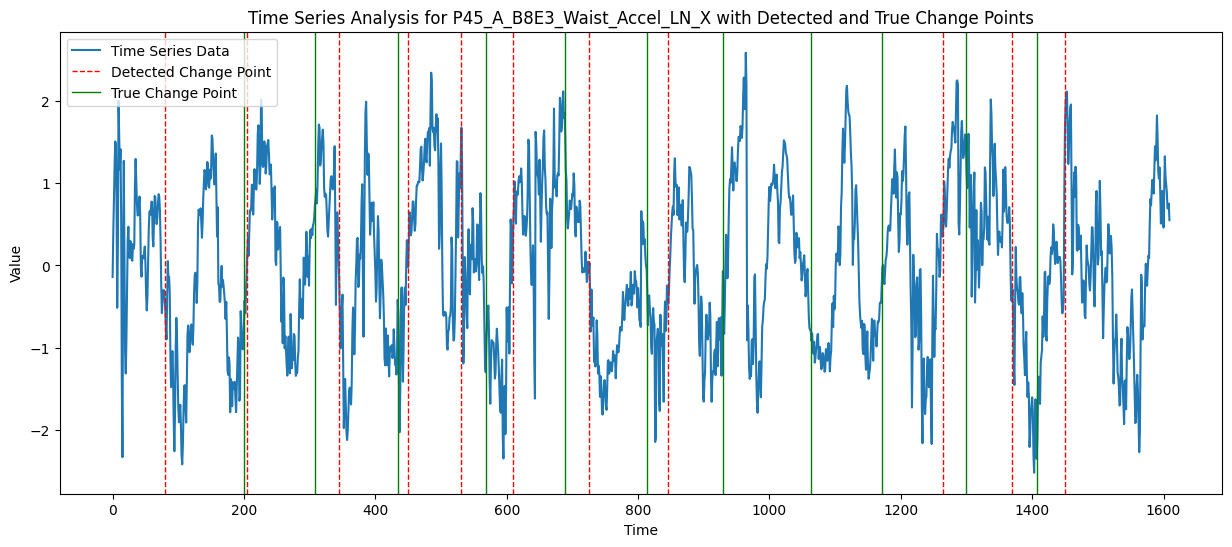

Found CPS: [ 340  585  675  755  935 1060 1145 1230 1320 1400 1490]
F1 Score: 0.4166666666666667
Covering Score: 0.5937117533946316
P45_A_B8E3_Waist_Accel_LN_Y - True Change Points: [200, 308, 435, 568, 689, 814, 930, 1063, 1171, 1299, 1408]
P45_A_B8E3_Waist_Accel_LN_Y - Detected Change Points: [ 340  585  675  755  935 1060 1145 1230 1320 1400 1490]
P45_A_B8E3_Waist_Accel_LN_Y - F1 Score: 0.417, Covering Score: 0.594
P45_A_B8E3_Waist_Accel_LN_Y - Algorithm Duration: 0.12 seconds


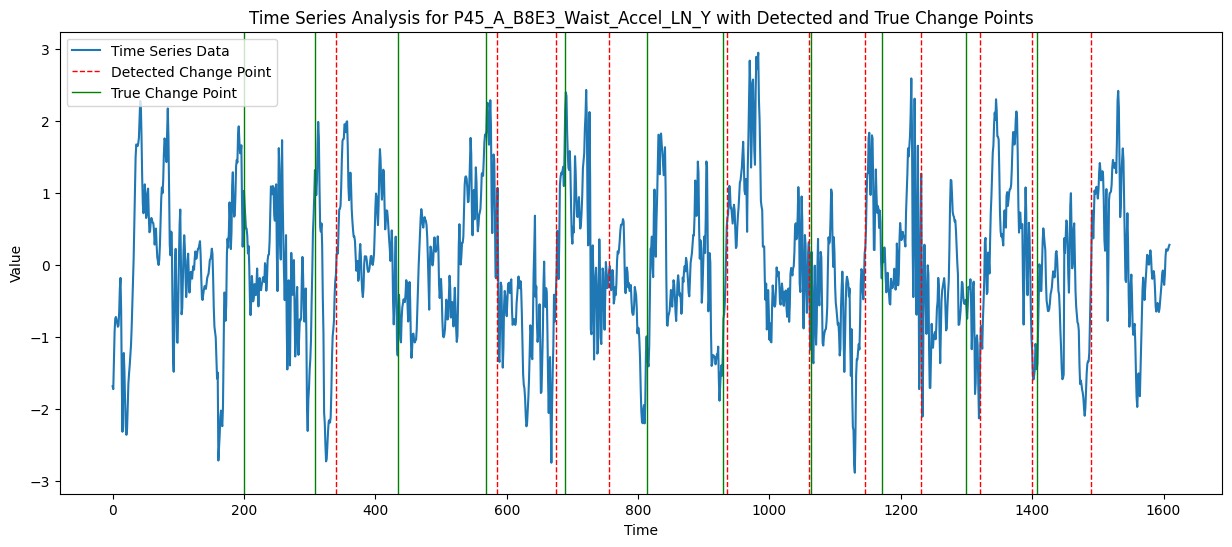

Found CPS: [105 185 270 350 430 510 590 670 750 830 915]
F1 Score: 0.4166666666666667
Covering Score: 0.4236633543301177
P45_A_B8E3_Waist_Accel_LN_Z - True Change Points: [200, 308, 435, 568, 689, 814, 930, 1063, 1171, 1299, 1408]
P45_A_B8E3_Waist_Accel_LN_Z - Detected Change Points: [105 185 270 350 430 510 590 670 750 830 915]
P45_A_B8E3_Waist_Accel_LN_Z - F1 Score: 0.417, Covering Score: 0.424
P45_A_B8E3_Waist_Accel_LN_Z - Algorithm Duration: 0.14 seconds


KeyboardInterrupt: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.binseg import binseg
from Functions.evaluate_binseg import evaluate_binseg
import time

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TRAIN_X.ts'
npy_file_path = '..//Data//Physio//TRAIN_pid.npy'

def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]
    return sub_series_data

change_points_and_pids = np.load(npy_file_path, allow_pickle=True)

all_sub_time_series_by_pid = {}
with open(ts_file_path, 'r') as file:
    for i, line in enumerate(file):
        pid = change_points_and_pids[i][0]
        sub_time_series = process_line(line)
        if pid not in all_sub_time_series_by_pid:
            all_sub_time_series_by_pid[pid] = []
        all_sub_time_series_by_pid[pid].append(sub_time_series)

all_complete_series = {}
for pid in all_sub_time_series_by_pid:
    transposed_series = list(zip(*all_sub_time_series_by_pid[pid]))
    all_complete_series[pid] = [np.concatenate(sub_series) for sub_series in transposed_series]

series_labels = [
    'B8E3_Waist_Accel_LN_X', 'B8E3_Waist_Accel_LN_Y', 'B8E3_Waist_Accel_LN_Z',
    'B8E3_Waist_Gyro_X', 'B8E3_Waist_Gyro_Y', 'B8E3_Waist_Gyro_Z', 
    'B8E3_Waist_Mag_X', 'B8E3_Waist_Mag_Y', 'B8E3_Waist_Mag_Z'
]

# Initialize accumulators for total time, F1 score, and coverage score
total_time = 0
total_f1_score = 0
total_covering_score = 0
series_processed = 0

for pid, complete_series in all_complete_series.items():
    all_cp_instances = [item for item in change_points_and_pids if np.array_equal(item[0], pid)]
    true_change_points = []
    for instance in all_cp_instances:
        if instance[-1] == '10' or instance[-1] == '11':
            true_change_points.extend([int(cp) for cp in instance[1:3] if cp.isdigit()])
        else:
            true_change_points.append(int(instance[1]))

    true_change_points = sorted(list(set(true_change_points)))

    for i, single_series in enumerate(complete_series):
        series_identifier = f"{pid}_{series_labels[i]}"
        cost_func = "l2"
        n_cps = min(len(true_change_points), len(single_series) - 1)

        start_time = time.time()
        detected_cps = binseg(single_series, n_cps, cost_func)
        end_time = time.time()

        algorithm_duration = end_time - start_time
        total_time += algorithm_duration

        try:
            dataset, true_cps, detected_cps, f1_score, covering_score = evaluate_binseg(series_identifier, single_series, true_change_points, cost_func=cost_func)
            print(f"{series_identifier} - True Change Points: {sorted(true_change_points)}")
            print(f"{series_identifier} - Detected Change Points: {detected_cps}")
            print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
            print(f"{series_identifier} - Algorithm Duration: {algorithm_duration:.2f} seconds")

            total_f1_score += f1_score
            total_covering_score += covering_score
            series_processed += 1

        except TypeError as e:
            print(f"An error occurred for {series_identifier}: {e}")

        plt.figure(figsize=(15, 6))
        plt.plot(single_series, label='Time Series Data')
        for cp in detected_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
        plt.legend()
        plt.show()

# Compute the average metrics
average_time = total_time / series_processed if series_processed > 0 else 0
average_f1_score = total_f1_score / series_processed if series_processed > 0 else 0
average_covering_score = total_covering_score / series_processed if series_processed > 0 else 0


In [ ]:
print(f"Average Algorithm Duration: {average_time:.5f} seconds")
print(f"Average F1 Score: {average_f1_score:.5f}")
print(f"Average Covering Score: {average_covering_score:.5f}")
print(f"Subseries processed: {series_processed}")